In [1]:
import sys

setupFlag = False
if setupFlag:
    !{sys.executable} -m pip install astroquery
    !{sys.executable} -m pip install eleanor
    !{sys.executable} -m pip install lightkurve

In [2]:
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

import eleanor
import astroquery
import tess_stars2px
import numpy as np
from astropy import units as u

import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.coordinates import SkyCoord
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()
import lightkurve as lk
import pandas as pd
import time

import csv
import dis
import inspect
import os
import sys
from IPython.display import display_html



In [3]:
## Some general functions 
def mkdir(directory): 
    ##https://gist.github.com/keithweaver/562d3caa8650eefe7f84fa074e9ca949
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

def unravel(list):
    return np.array([i for array in list for i in array])

savePNG = True
if savePNG:
    mpl.use("agg")
    plotExt = str('.png')
elif not savePNG:
    mpl.use("pgf")
    mpl.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,})
    plotExt = str('.pgf')

#%matplotlib inline
%matplotlib notebook

In [4]:
coords = SkyCoord('13 23 29.02  +62 26 46.3',unit=(u.hourangle,u.deg))
sn2020bpi = eleanor.Source(coords=coords)
print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(sn2020bpi.tic, sn2020bpi.gaia, sn2020bpi.tess_mag, sn2020bpi.coords[0], sn2020bpi.coords[1]))
#testcoord = SkyCoord(ra=sn2020bpi.coords[0],dec=sn2020bpi.coords[1],unit=(u.deg,u.deg))
data = eleanor.TargetData(sn2020bpi, height=15, width=15, do_psf=True, do_pca=True)
# time.sleep(.1)

No eleanor postcard has been made for your target (yet). Using TessCut instead.
Found TIC 367602816 (Gaia 1663967469745820672), with TESS magnitude 16.9863, RA 200.87091666666663, and Dec 62.446194444444444




100%|██████████| 1248/1248 [00:26<00:00, 46.56it/s]


<IPython.core.display.Javascript object>


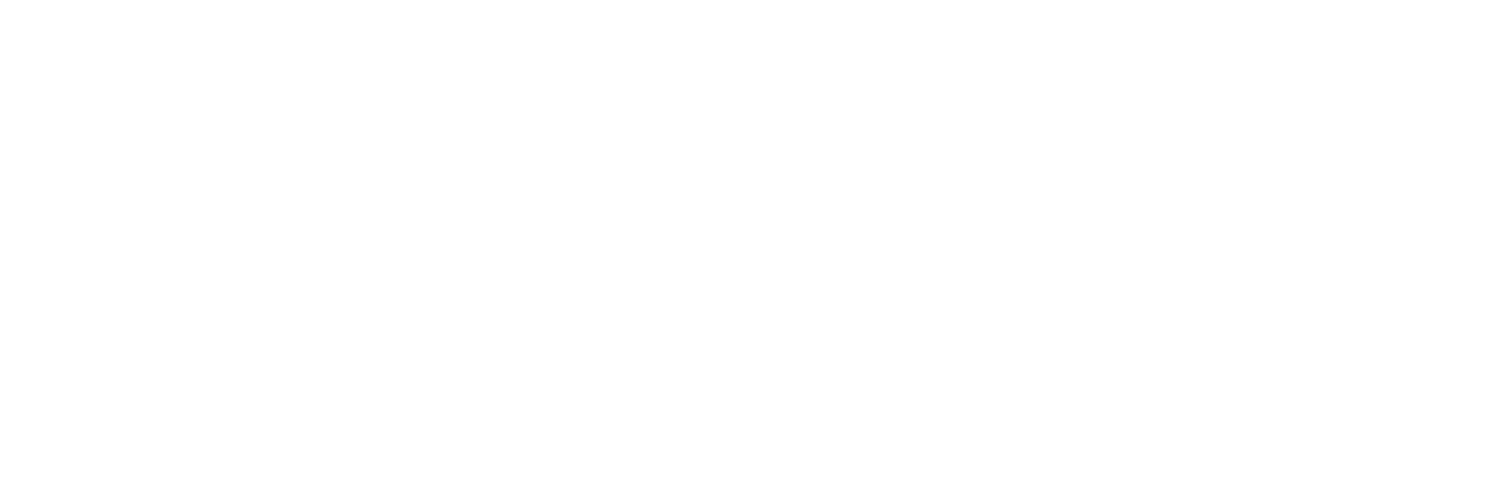

<IPython.core.display.Javascript object>


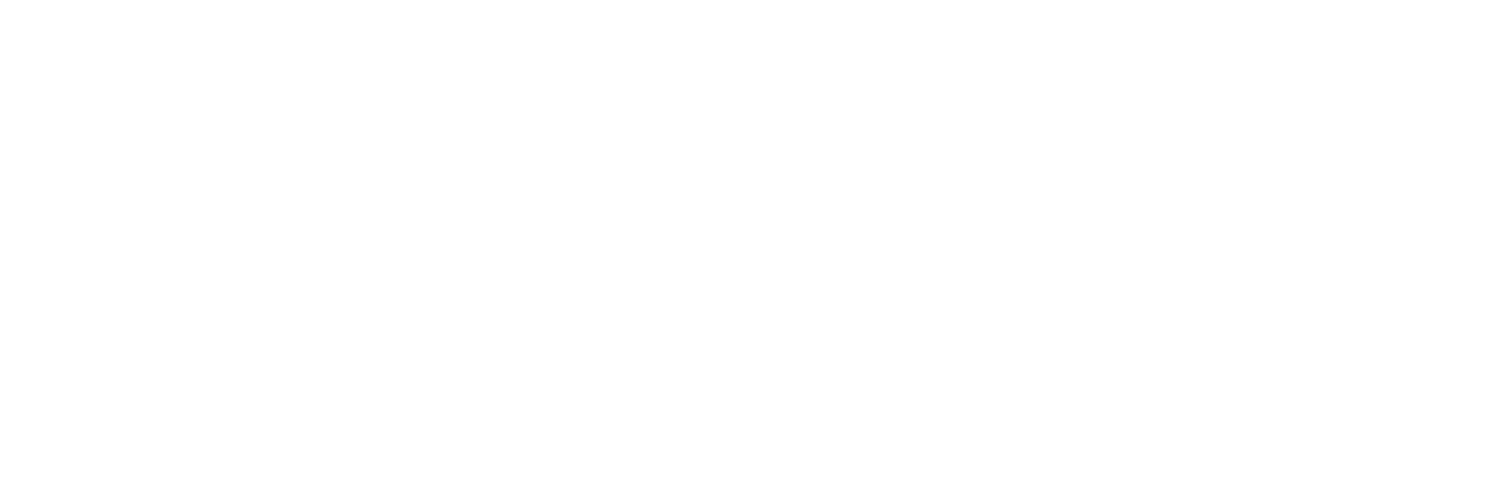

<IPython.core.display.Javascript object>


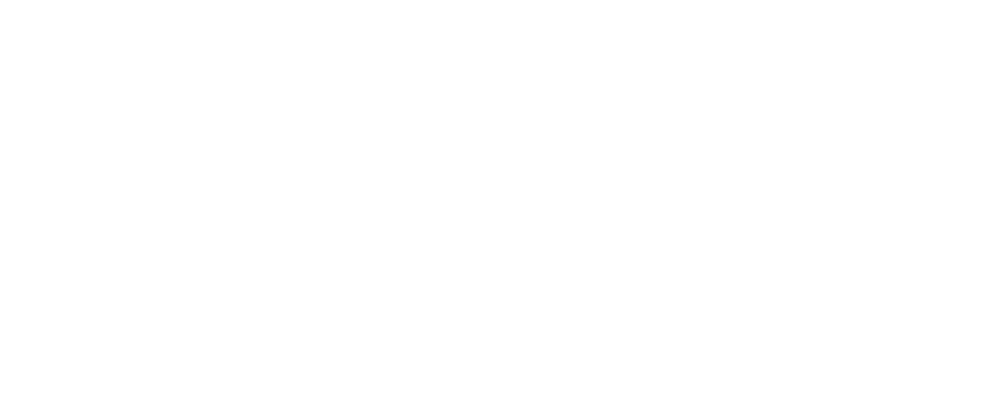

<IPython.core.display.Javascript object>


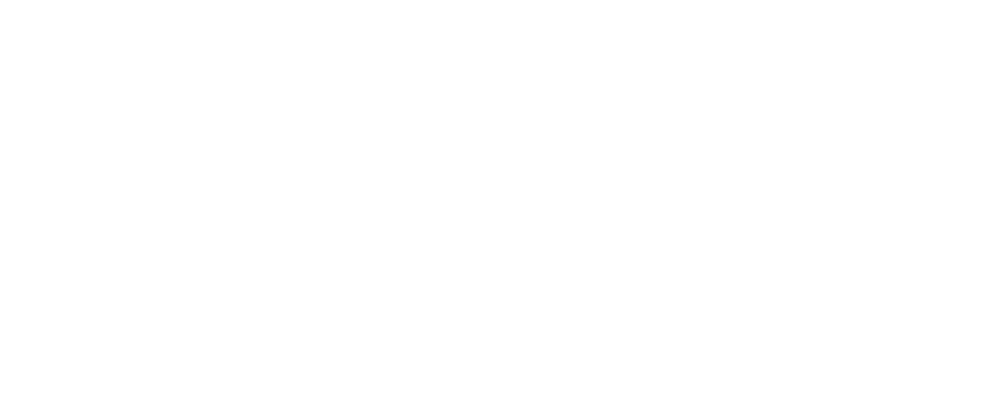

In [5]:
plt.figure(figsize=(15,5))

q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q])+0.06, 'k')
plt.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) + 0.03, 'r')
plt.plot(data.time[q], data.pca_flux[q]/np.nanmedian(data.pca_flux[q]), 'g')
plt.plot(data.time[q], data.psf_flux[q]/np.nanmedian(data.psf_flux[q]) - 0.02, 'b')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')

plt.figure(figsize=(15,5))

plt.plot(data.time, data.flux_bkg, 'k', label='1D postcard', linewidth=3)
plt.plot(data.time, data.tpf_flux_bkg, 'r--', label='1D TPF', linewidth=2)
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.legend();

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.bkg_tpf[0])
ax2.set_title('2D interpolated background');

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
ax1.imshow(data.tpf[0])
ax1.set_title('Target Pixel File')
ax2.imshow(data.aperture)
ax2.set_title('Aperture');

In [6]:
# peakTime = lk2020.time[np.argmax(lk2020.flux)] ## btjd of peak
# #print(maxTime)
# peakTimeAstro = lk.utils.btjd_to_astropy_time(peakTime) ## astropy time product of peak
# peakTimeAstro.fits
# #time_support()
# #quantity_support()
# lk.utils.btjd_to_astropy_time(lk2020.time[0]).fits ## earliest date
# #dateTest = lk.utils.btjd_to_astropy_time(lk2020.time)
# dateTest = lk2020.astropy_time - Time("2020-02-14",format="iso").jd
# # with time_support() and quantity_support():
# plt.figure()
# plt.plot(dateTest, lk2020.flux,color=(0,.6,0.5))
# plt.xlabel("test")
# plt.ylabel("test")
# #plt.plot(lk2020.time, lk2020.flux)
# plt.locator_params(axis='x', nbins=10)
# #plt.axvline(x=Time(dateTest[0],format="isot"))
# plt.axvline(x=dateTest.jd[np.argmax(lk2020.flux)],color=(0.8,0.4,0),linestyle='dashed')
# plt.xticks(rotation=20)


# print(dateTest[0].jd)
# print(dateTest[-1])
# print(np.argmax(lk2020.flux))
# print(lk2020.time)
# print(dateTest.jd[np.argmax(lk2020.flux)])

Unfortunately, it seems the earliest date SN 2020bpi was observed by TESS was February 19th, five days after the estimated peak. However, on March 5th, there is a noticeable peak in the flux. Not sure what that is 

In [5]:
def snStats(radec, peak, sector=None, tpfSize=15, 
            plot=False, savePlot=False, targetName=None, verbose=False):
    ## Uses eleanor to search for target SN in TESS field and identifies if peak is observed
    ## radec is taken as string in form 'hh mm ss +dd mm ss'
    ## peak is taken as string in form 'yyyy-mm-dd hh:mm:ss' or 'yyyy-mm-dd' (ie iso format)
    ## tpfSize is size of produced target pixel file in pixels (must be an odd number) 
    coords = SkyCoord(radec,unit=(u.hourangle,u.deg));
    if sector:
        target = eleanor.Source(coords=coords,sector=sector);
    elif not sector:
        target = eleanor.Source(coords=coords);
    data = eleanor.TargetData(target, height=tpfSize, width=tpfSize, do_psf=False, do_pca=False);
    ticCoords = SkyCoord(ra=target.coords[0],dec=target.coords[1],unit=(u.deg,u.deg))
    time.sleep(0.10)
    peakTime = Time(peak, format='iso')
    obsStartTime = lk.utils.btjd_to_astropy_time(data.time)[0]
    obsEndTime = lk.utils.btjd_to_astropy_time(data.time)[-1]
    peakTimePres = obsStartTime.jd <= peakTime.jd <= obsEndTime.jd
    if not peakTimePres:
        timeDiff = np.around(peakTime.to_value('jd') - 
                             min([obsStartTime.to_value('jd'), obsEndTime.to_value('jd')], 
                                 key=lambda x:abs(x-peakTime.to_value('jd'))),2)
        print("Warning: provided peak is "+str(timeDiff)+" days outside of TESS time range")
        
    lc = data.to_lightkurve()
    daysFromPeak = lk.utils.btjd_to_astropy_time(lc.time) - peakTime.jd 
    obsPeak = Time(np.str(lc.time[np.argmax(lc.flux)]+2457000),format='jd')
    if verbose:
        print()
        print("Target Name: "+targetName if targetName else "")
        print("TESS Input Catalog (TIC) ID: "+str(target.tic))
        print("Located at: "+ticCoords.to_string('hmsdms'), end=" ")
        print("(exact target)" if ticCoords.ra==coords.ra and 
              ticCoords.dec==coords.dec else "(closest target)")
        print("TESS Sector: "+str(target.sector))
        print("Observation Start: "+obsStartTime.iso)
        print("Observation End: "+obsEndTime.iso)
        print("Observation Length: "+
              str(np.around(obsEndTime.to_value('jd') - obsStartTime.to_value('jd'),3))+' days')
        print("Peak Flux of "+str(np.around(np.max(lc.flux),3))+
              " e/s Observed on "+str(obsPeak.iso))
        print()
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,4))
        ax1.imshow(data.tpf[0])
        ax1.set_title('Target Pixel File')
        ax2.imshow(data.bkg_tpf[0])
        ax2.set_title('2D interpolated background')
        ax3.imshow(data.aperture)
        ax3.set_title('Aperture')
        plotTitle = str(targetName+' (TIC '+
                        str(target.tic)+')') if targetName else str("Identified Target (TIC "
                                                                        +str(target.tic)+")")
        fig.suptitle(plotTitle)
        if savePlot:
            saveDir = str("./"+targetName+"/") if targetName else str("./TIC "+str(target.tic)+"/")
            mkdir(saveDir)
            fig.savefig(saveDir+"TPF"+plotExt, bbox_inches='tight')
        plt.show()
        
        plt.figure(figsize=(15,5))
        plt.plot(daysFromPeak, lc.flux/np.median(lc.flux), color=(0,0.6,0.5), label="Lightcurve")
        plt.axvline(x=daysFromPeak.jd[np.argmax(lc.flux)], color=(0,0,0),
                   linestyle='dotted', label='Max Flux: '+str(np.around(np.max(lc.flux),3))+' e/s')
        if peakTimePres:
            plt.axvline(x=0, color=(0.8,0.4,0), 
                        linestyle='dashed', label='Estimated Peak')
        plt.locator_params(axis='x', nbins=10)
        plt.xticks(rotation=20)
        plt.xlabel('Days From Estimated Peak')
        plt.ylabel('Normalized Flux')
        plt.legend()
        plt.title(plotTitle)
        if savePlot:
            saveDir = str("./"+targetName+"/") if targetName else str("./TIC "+str(target.tic)+"/")
            mkdir(saveDir)
            fig.savefig(saveDir+"lightcurve"+plotExt, bbox_inches='tight')
        plt.show()
        
    return [daysFromPeak, lc]

No eleanor postcard has been made for your target (yet). Using TessCut instead.

Target Name: SN 2020bpi
TESS Input Catalog (TIC) ID: 367602816
Located at: 13h23m29.02s +62d26m46.3s (exact target)
TESS Sector: 21
Observation Start: 2020-01-21 22:48:43.352
Observation End: 2020-02-18 06:19:27.486
Observation Length: 27.313 days
Peak Flux of 62.833 e/s Observed on 2020-02-05 11:19:14.037



<IPython.core.display.Javascript object>


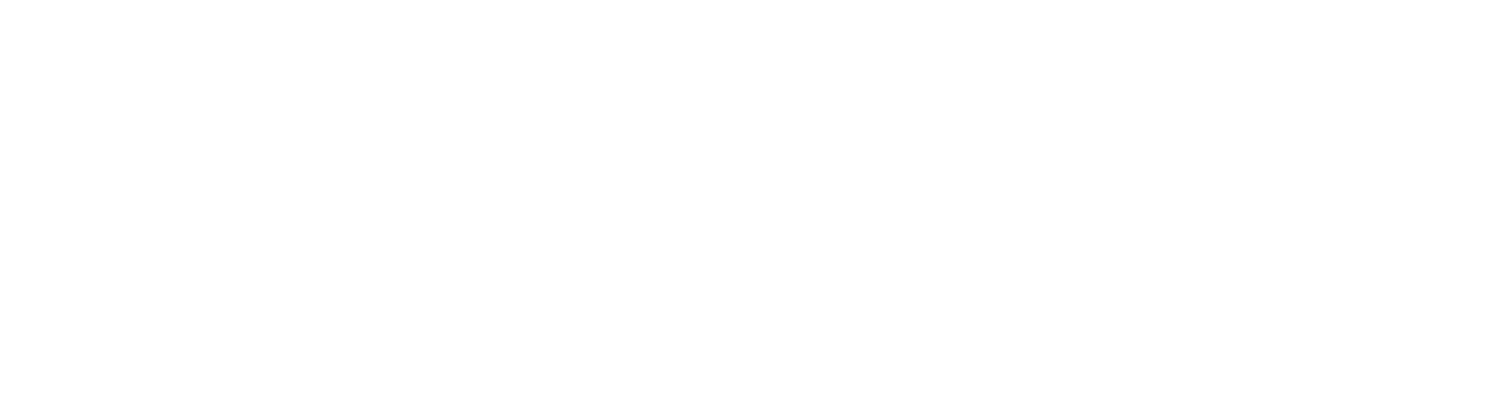

<IPython.core.display.Javascript object>


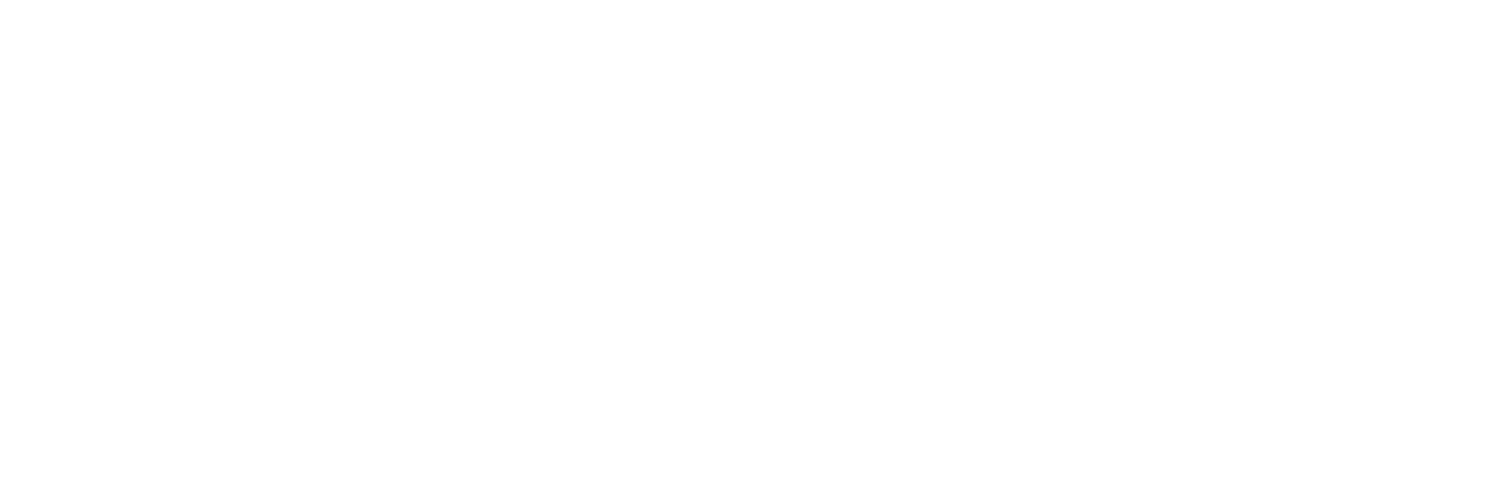

In [8]:
test = snStats(radec='13 23 29.02  +62 26 46.3',peak='2020-02-14', sector=21,
        plot=True,targetName='SN 2020bpi',verbose=True)

In [9]:
snStats(radec='14 53 30.373 +17 17 20.97',peak='2020-03-09',
        plot=True,targetName='SN 2020dhj',verbose=True)

SearchError: Tess has not (yet) observed your target.

In [10]:
snStats(radec='13 27 15.176 +32 02 00.74',peak='2020-03-19',
        plot=True,targetName='SN 2020ees',verbose=True)

ValueError: zero-size array to reduction operation minimum which has no identity

In [11]:
snStats(radec='15 34 33.036 +37 32 01.85',peak='2020-04-19',
        plot=True,targetName='SN 2020fxa',verbose=True)

ValueError: zero-size array to reduction operation minimum which has no identity

No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...

Target Name: SN 2020jdo
TESS Input Catalog (TIC) ID: 10002089115
Located at: 18h15m43.648s +58d12m54.81s (exact target)
TESS Sector: 22
Observation Start: 2020-02-19 19:44:39.603
Observation End: 2020-03-17 23:15:08.973
Observation Length: 27.146 days
Peak Flux of 140.085 e/s Observed on 2020-02-19 19:44:39.603



<IPython.core.display.Javascript object>


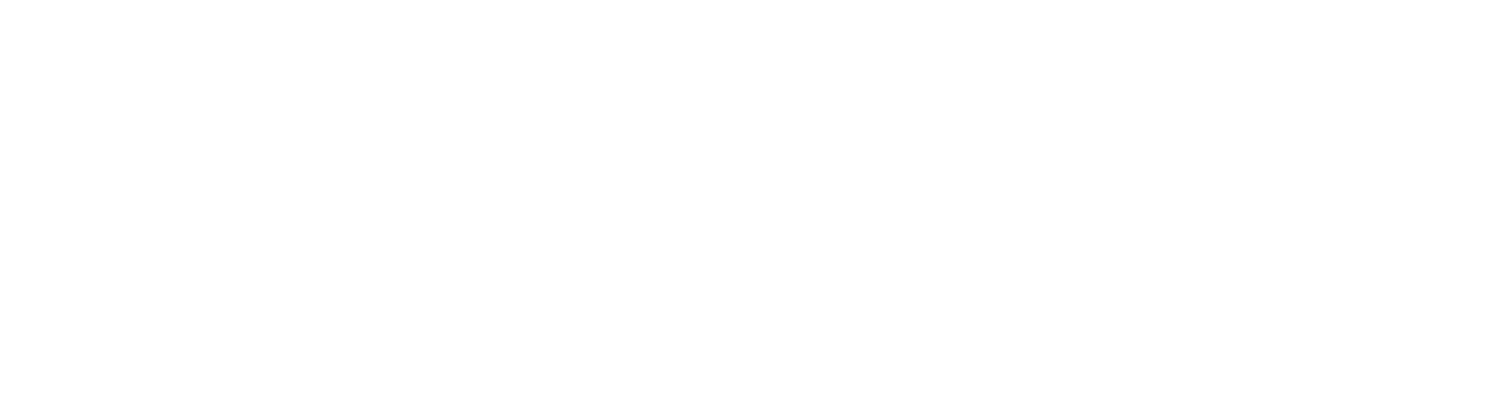

<IPython.core.display.Javascript object>


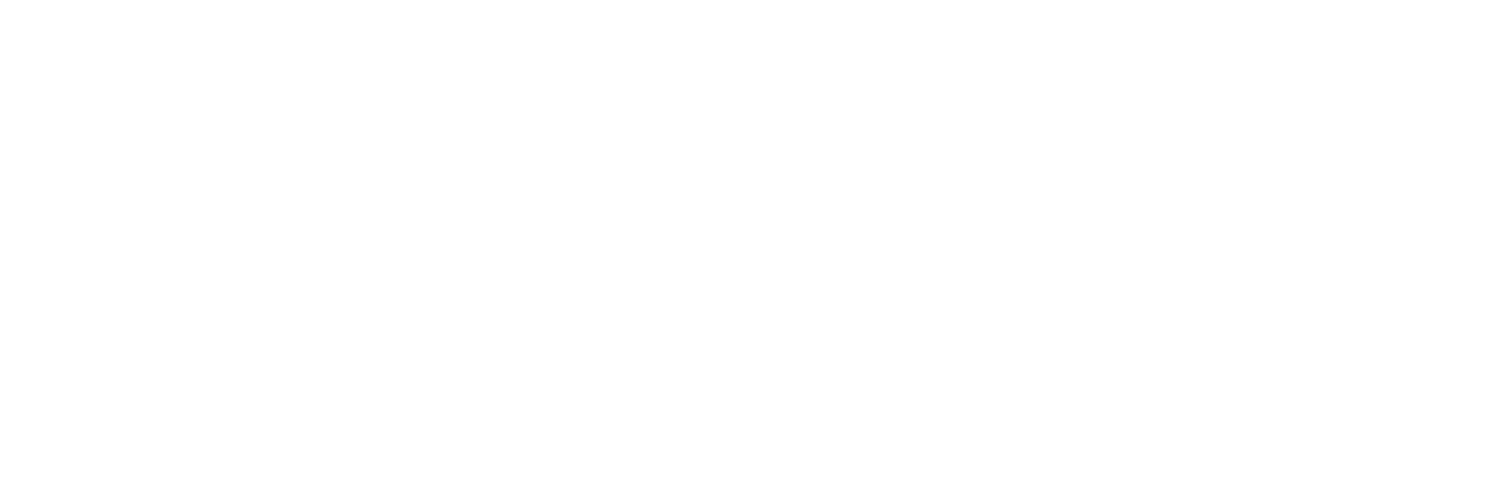

[<Time object: scale='tdb' format='jd' value=[-86.17731941 -86.07313182 -86.05231871 ... -59.0728331  -59.0519591
  -59.03114614]>,
 TessLightCurve(TICID: 10002089115)]

In [12]:
snStats(radec='18 15 43.648 +58 12 54.81',peak='2020-05-16',
        plot=True,targetName='SN 2020jdo',verbose=True)

INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0008-1-2-cal-0608-0376_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0008-1-2-cal-0608-0376_tess_v2_bkg.fits with expected size 59621760. [astroquery.query]
INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0008-1-2-cal-0608-0376_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0008-1-2-cal-0608-0376_tess_v2_pc.fits with expected size 119327040. [astroquery.query]
INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0008-1-2-cal-0608-0376_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0008-1-2_tess_v2_pm.txt with expected size 180747. [astroquery.query]

Target Name: SN 2020jgl
TESS Input Catalog (TIC) ID: 10002409466
Located at: 09h28m58.431s -14d48m19.76s (exact target)
TESS Sector: 8
Observation Start: 2019-02-02 20:52:43.392
Observation End: 2019-02-27 11:52:58.002
Observation Length: 24.625 days
Peak Flux of 3129.7

<IPython.core.display.Javascript object>


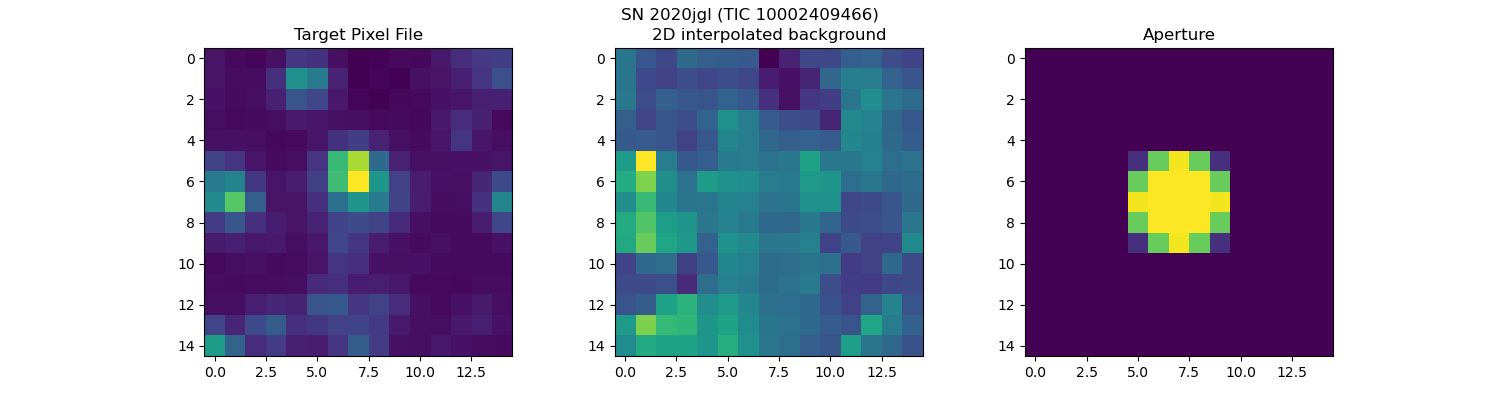

<IPython.core.display.Javascript object>


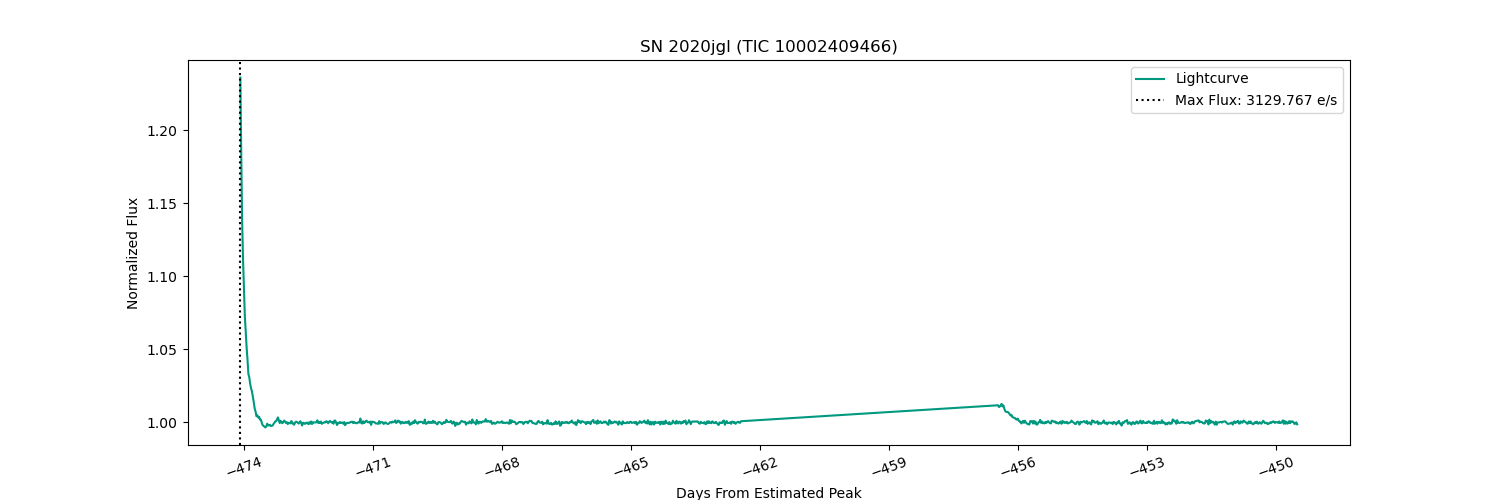

[<Time object: scale='tdb' format='jd' value=[-474.08838557 -474.06755169 -474.04671781 -474.02588394 -474.00505007
  -473.9842162  -473.94254847 -473.92171462 -473.90088076 -473.88004691
  -473.85921306 -473.83837922 -473.81754537 -473.79671153 -473.77587769
  -473.75504385 -473.73421002 -473.71337618 -473.69254234 -473.67170851
  -473.65087467 -473.63004084 -473.609207   -473.58837316 -473.56753932
  -473.52587164 -473.5050378  -473.48420395 -473.46337011 -473.44253626
  -473.42170241 -473.40086855 -473.3800347  -473.33836699 -473.31753313
  -473.29669927 -473.27586541 -473.25503155 -473.21336383 -473.17169611
  -473.15086226 -473.1300284  -473.10919455 -473.06752685 -473.02585917
  -473.00502533 -472.98419149 -472.96335766 -472.94252383 -472.92169
  -472.90085618 -472.88002236 -472.85918854 -472.83835473 -472.81752092
  -472.79668711 -472.7758533  -472.75501949 -472.73418569 -472.71335188
  -472.69251808 -472.67168427 -472.65085047 -472.63001666 -472.60918286
  -472.58834905 -472.56

In [10]:
snStats(radec='09 28 58.431 -14 48 19.76',peak='2020-05-22',
        plot=True,targetName='SN 2020jgl',verbose=True)

In [14]:
snStats(radec='15 38 10.148 +04 46 50.39',peak='2020-06-05',
        plot=True,targetName='SN 2020kpx',verbose=True)

SearchError: Tess has not (yet) observed your target.

In [15]:
snStats(radec='16 13 45.538 +22 55 14.36',peak='2020-06-09',
        plot=True,targetName='SN 2020kyx',verbose=True)

SearchError: Tess has not (yet) observed your target.

In [16]:
snStats(radec='14 37 59.666 +09 23 18.81',peak='2020-06-14',
        plot=True,targetName='SN 2020lil',verbose=True)

SearchError: Tess has not (yet) observed your target.

In [6]:
snStats(radec='16 07 23.346 +13 53 33.44',peak='2020-07-11',
        plot=True,targetName='SN2020nta',verbose=True)

SearchError: Tess has not (yet) observed your target.

In [7]:
snStats(radec='20 04 29.829 +09 20 00.31',peak='2020-07-21',
        plot=True,targetName='SN2020oyd',verbose=True)

SearchError: Tess has not (yet) observed your target.

In [8]:
snStats(radec=' 01 13 12.033 +02 17 01.92',peak='2020-08-01',
        plot=True,targetName='SN2020pst',verbose=True)

SearchError: Tess has not (yet) observed your target.

Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector 17...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector 17 now available.
No eleanor postcard has been made for your target (yet). Using TessCut instead.
Inflating...

Target Name: SN2020qic
TESS Input Catalog (TIC) ID: 601098217
Located at: 00h15m05.611s +43d20m35.64s (exact target)
TESS Sector: 17
Observation Start: 2019-10-08 04:52:04.130
Observation End: 2019-11-02 04:21:49.638
Observation Length: 24.979 days
Peak Flux of 287.227 e/s Observed on 2019-10-19 15:22:06.292



<IPython.core.display.Javascript object>


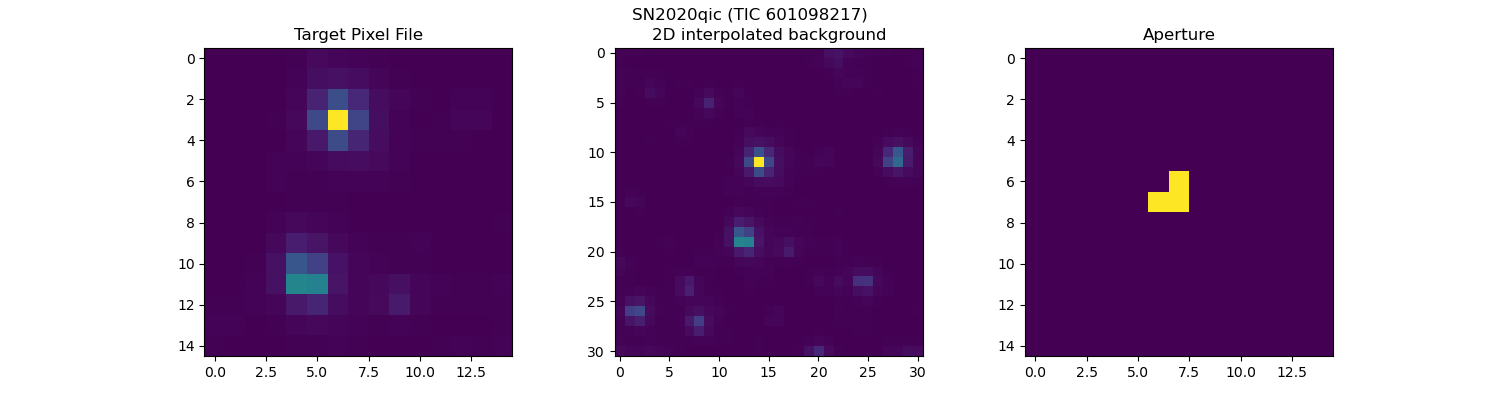

<IPython.core.display.Javascript object>


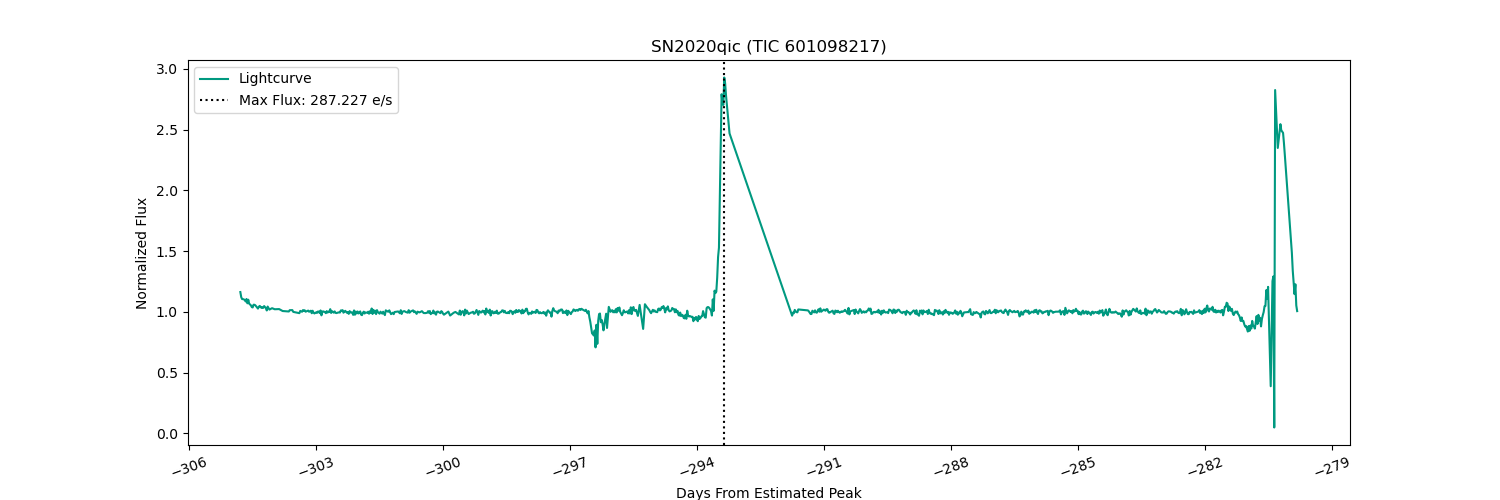

[<Time object: scale='tdb' format='jd' value=[-304.79717442 -304.77636139 -304.75548733 -304.73467429 -304.69298718
  -304.67217414 -304.65136109 -304.630487   -304.60967395 -304.58886089
  -304.54717372 -304.52636064 -304.50548653 -304.48467345 -304.46386037
  -304.44298624 -304.38048592 -304.35967282 -304.33885971 -304.29717246
  -304.27635935 -304.2554852  -304.23467209 -304.19298482 -304.17217171
  -304.15135859 -304.10967133 -304.04717095 -304.02635784 -303.98467058
  -303.88048296 -303.7971695  -303.6512946  -303.63048148 -303.56798108
  -303.54710691 -303.40129287 -303.38047972 -303.33879238 -303.31797923
  -303.29710504 -303.27629189 -303.25547873 -303.19297824 -303.17210405
  -303.13047775 -303.10960356 -303.08879041 -303.06797726 -303.04710308
  -303.0054768  -302.98460262 -302.96378948 -302.94297634 -302.92210217
  -302.90128903 -302.8804759  -302.85960173 -302.83878859 -302.79710129
  -302.77628816 -302.75547502 -302.73460085 -302.71378771 -302.69297458
  -302.6721004  -302

In [9]:
snStats(radec='00 15 05.611 +43 20 35.64',peak='2020-08-08',
        plot=True,targetName='SN2020qic',verbose=True)

INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]

Target Name: ASASSN-18tb
TESS Input Catalog (TIC) ID: 10000583619
Located at: 04h18m06.149s -63d36m56.68s (exact target)
TESS Sector: 1
Observation Start: 2018-07-25 19:46:39.110
Observation End: 2018-08-22 15:47:10.881
Observation Length: 27.834 days
Peak Flux of 92.35

<IPython.core.display.Javascript object>


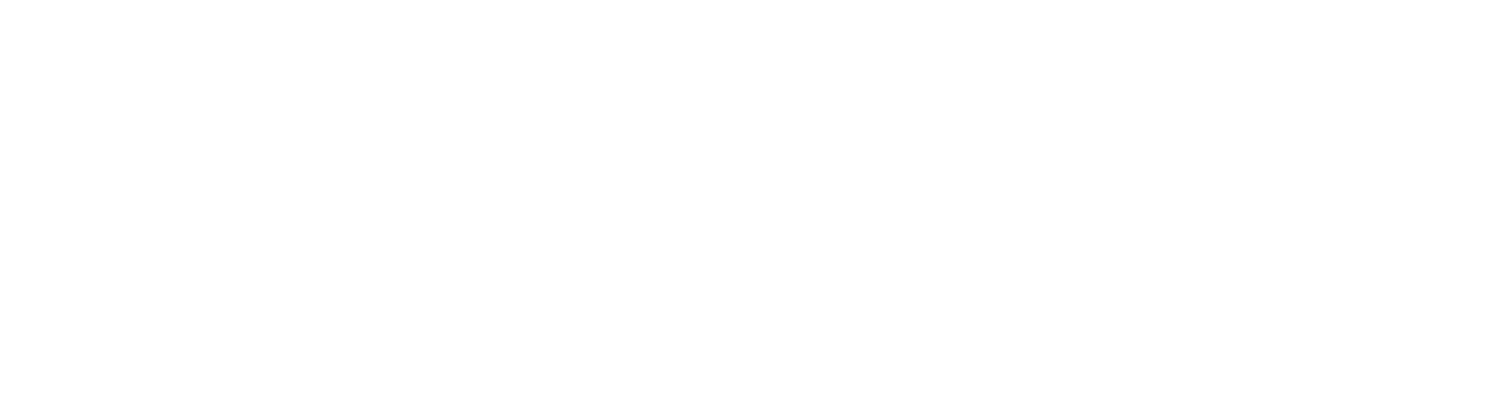

<IPython.core.display.Javascript object>


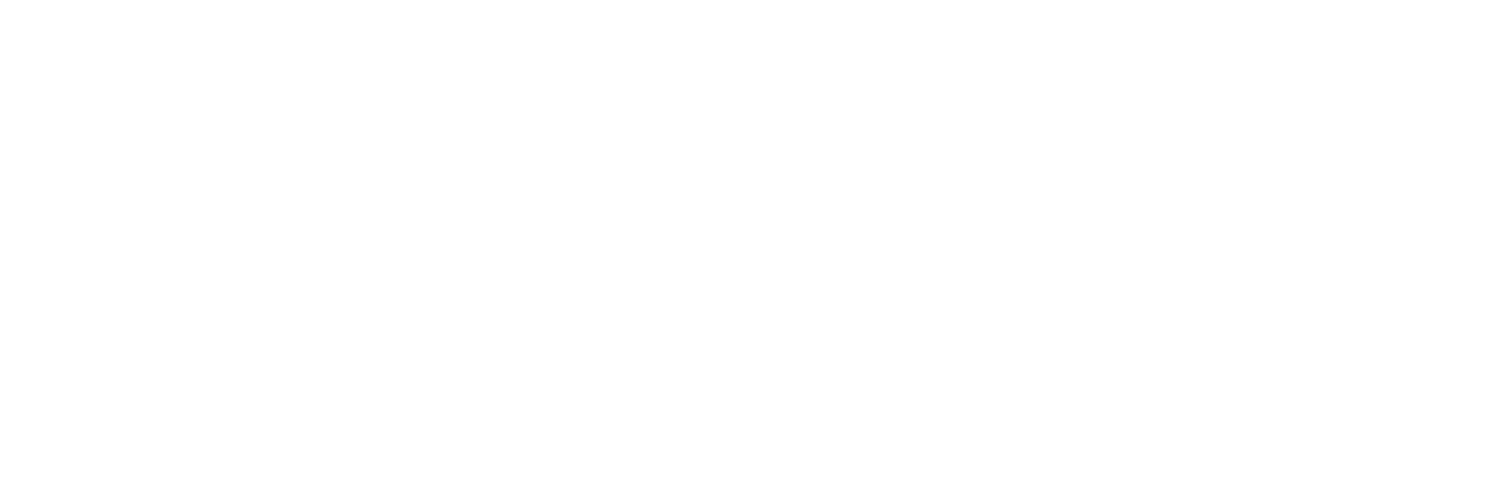

<IPython.core.display.Javascript object>


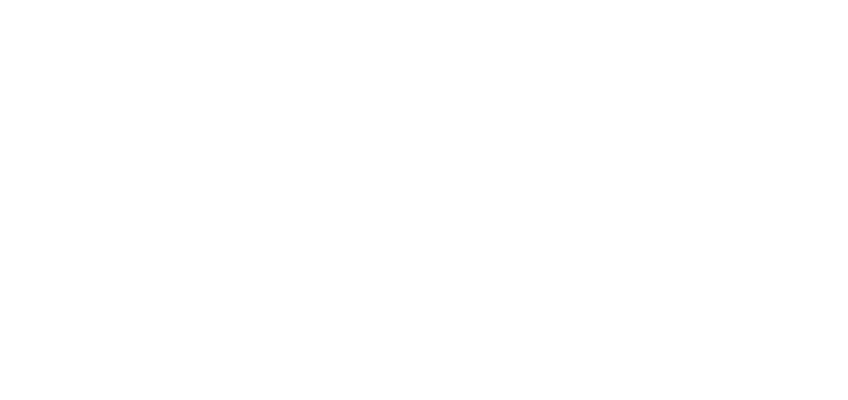

In [17]:
asassn = snStats(radec='04 18 06.149 −63 36 56.68', sector=1, peak='2018-08-27 07:55:12.000',
        plot=True,targetName='ASASSN-18tb',verbose=True)
asassn[1].plot() 

Found star in Sector(s) 1 2 3 4 5 7 8 9 10 11 12 13
INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file /home/tpb53/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0706-0808_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]
Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  3...
This will only take a minute, and only needs to be done once. Any other light curves you make 

Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector 13 now available.
[1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13]
INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                f

<IPython.core.display.Javascript object>


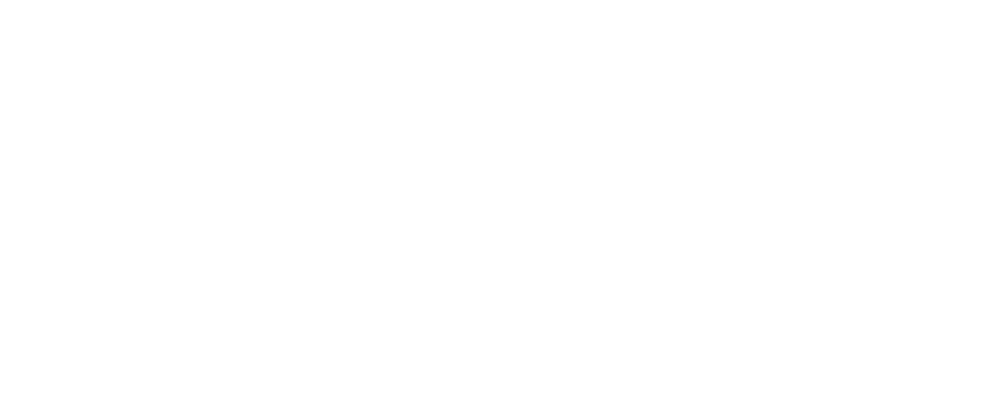

<IPython.core.display.Javascript object>


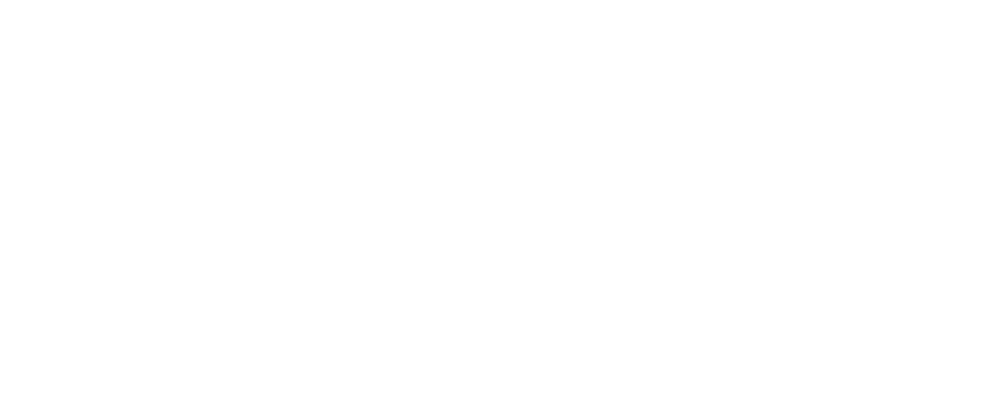

<IPython.core.display.Javascript object>


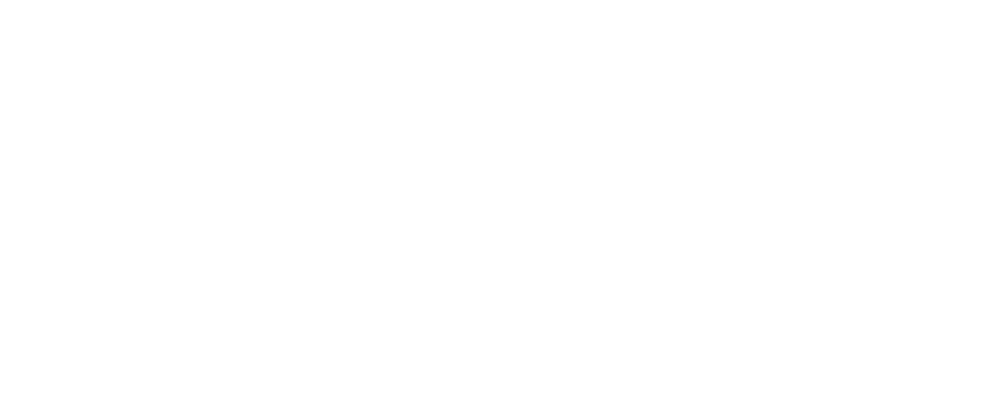

<IPython.core.display.Javascript object>


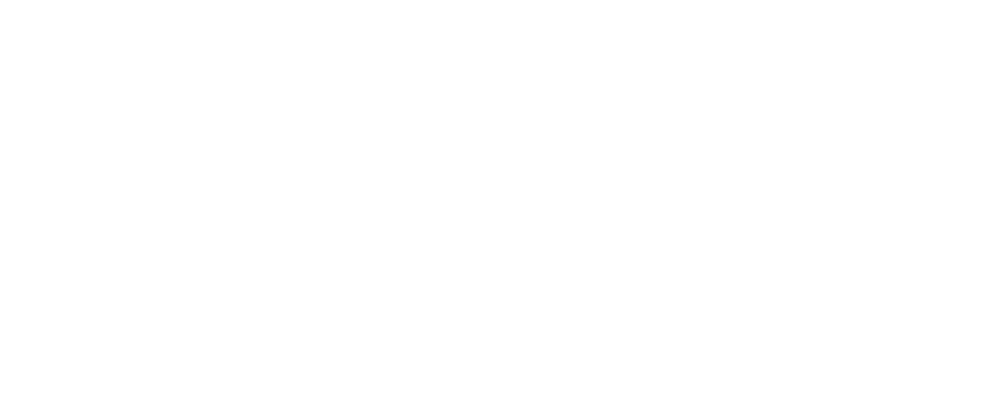

<IPython.core.display.Javascript object>


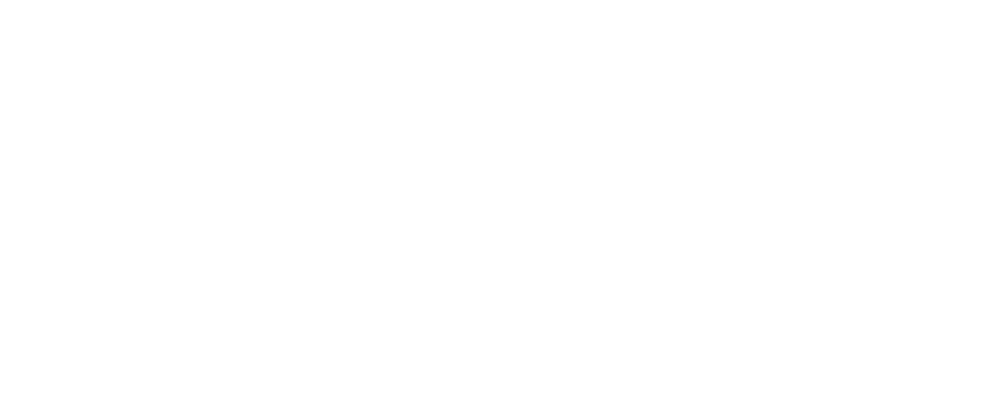

<IPython.core.display.Javascript object>


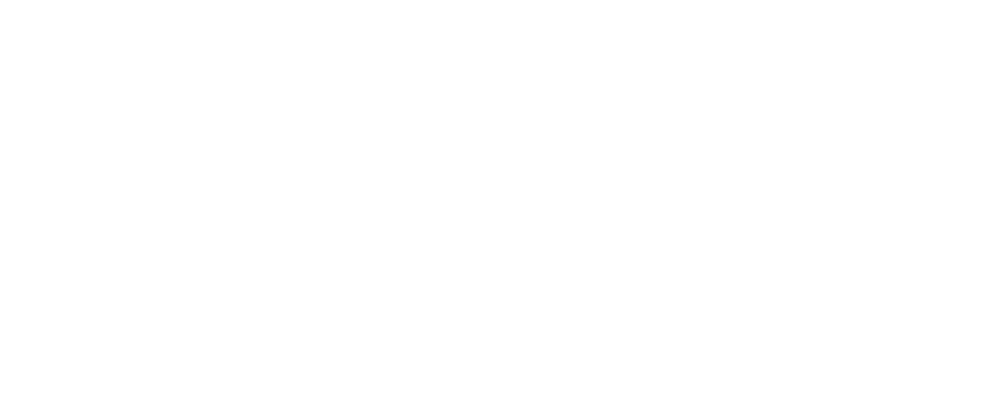

<IPython.core.display.Javascript object>


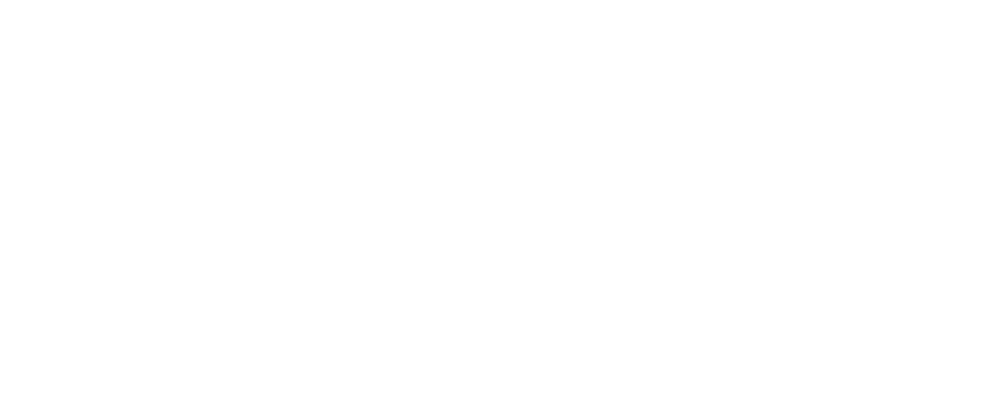

<IPython.core.display.Javascript object>


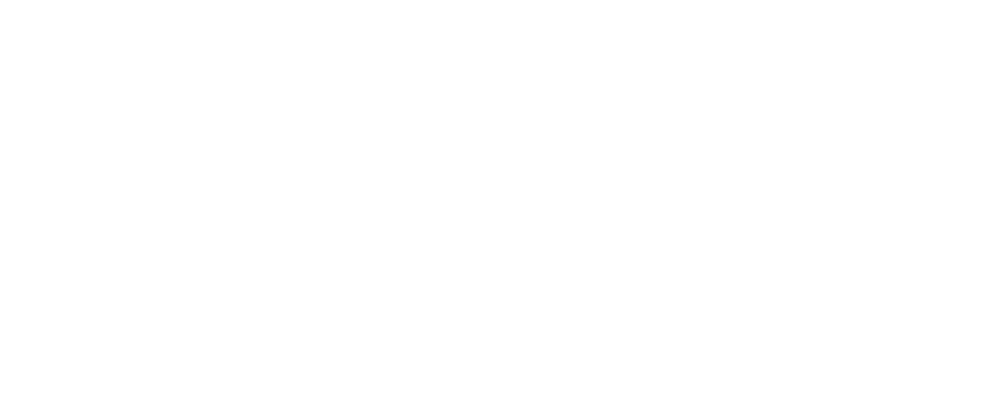

<IPython.core.display.Javascript object>


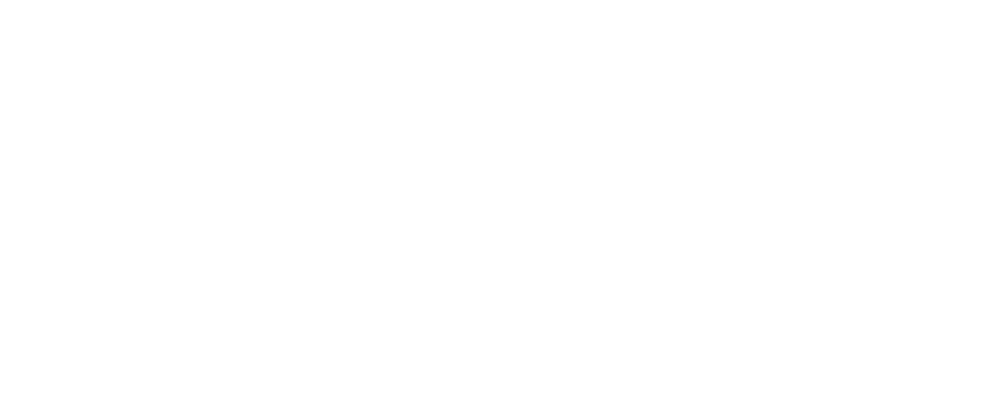

<IPython.core.display.Javascript object>


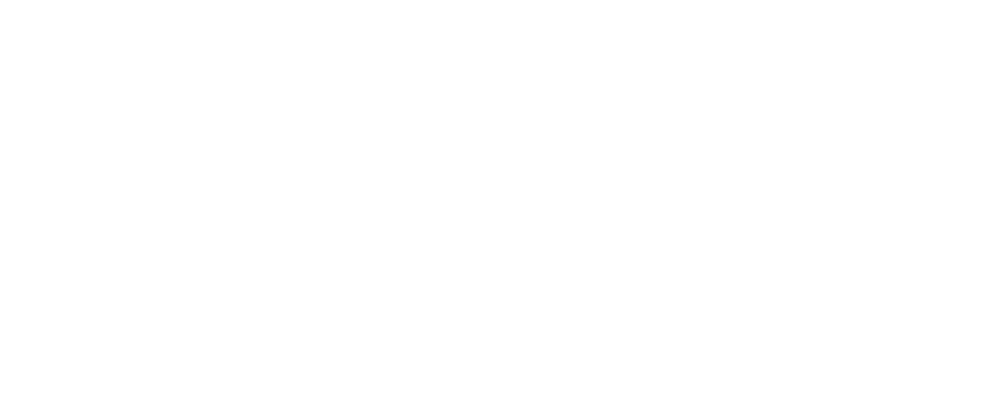

<IPython.core.display.Javascript object>


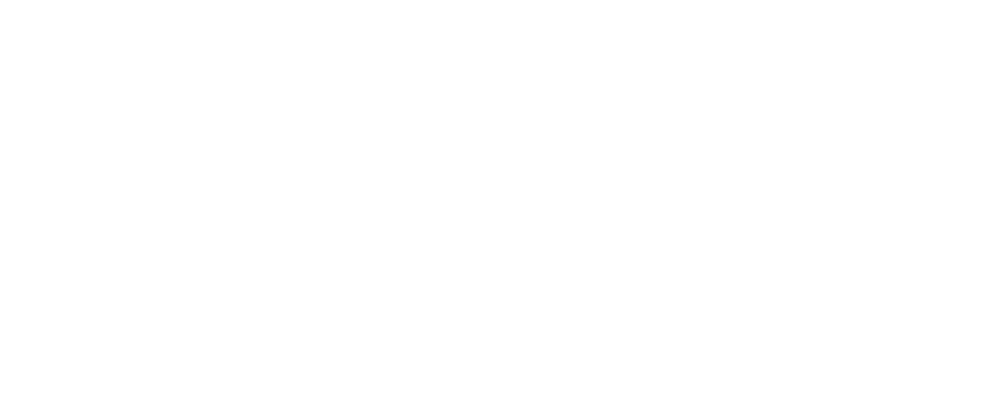

<IPython.core.display.Javascript object>


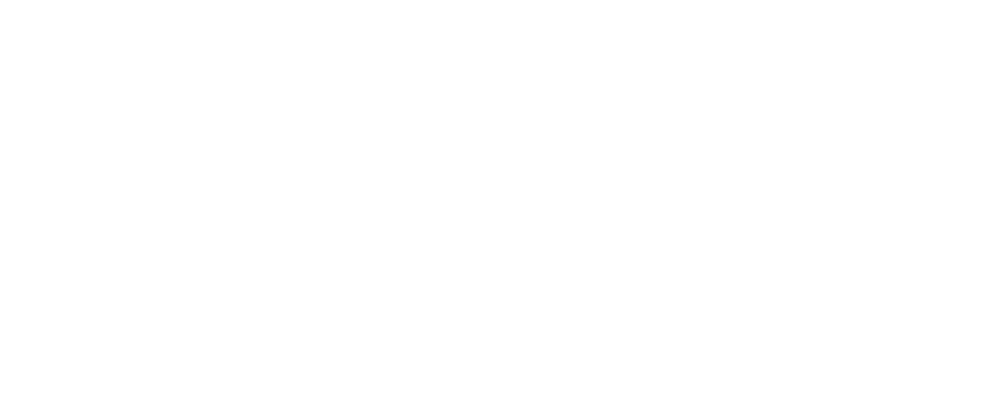

In [18]:

tCoord = SkyCoord('04 18 06.149 −63 36 56.68',unit=(u.hourangle,u.deg))
target = eleanor.multi_sectors(coords=tCoord,sectors='all')
#sec = [21,22]
#sec = 'all'
#target = eleanor.multi_sectors(coords=tCoord,sectors=sec)
# print(len(target))
#print(target[0].sector)
sectors= [target[sec].sector for sec in range(len(target))]
print(sectors)
# for i in range(len(target)):
#     print(target[i].sector)
#target.pm_dir = "C:\\Users\\Tyler\\.eleanor\\mastDownload\\HLSP\\"
data = []
for targ in target:
    for i in range(10):
        try:
            time.sleep(0.15)
            datum = eleanor.TargetData(targ, height=15, do_psf=False, do_pca=False)
            data.append(datum)
        except ValueError:
            print('fail number '+str(i))
            continue
        else:
            break
    else:
        print('didn\'t work')
for sector, datum in enumerate(data):
    q = datum.quality == 0
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4))
    ax1.imshow(datum.tpf[q][0])
    ax1.set_title('Target Pixel File')
    ax2.imshow(datum.aperture)
    ax2.set_title('Aperture');
    plt.show()
for sector, datum in enumerate(data):
    q = datum.quality == 0
    plt.plot(datum.time[q],datum.corr_flux[q]/np.nanmedian(datum.corr_flux[q]))#,['k.', 'r.'])
#lk = data.to_lightcurve()
#lk.plot()
#ticCoords = SkyCoord(ra=target.coords[0],dec=target.coords[1],unit=(u.deg,u.deg))

In [19]:
%%capture
tCoord = SkyCoord('04 18 06.149 −63 36 56.68',unit=(u.hourangle,u.deg));
target = eleanor.multi_sectors(coords=tCoord,sectors='all');
targets = []
sectors= [target[sec].sector for sec in range(len(target))];
#tsec = [print(sect) for sect in sectors]
#targets = [eleanor.Source(coords=tCoord,sector=sec) for sec in sectors]
#targets = eleanor.multi_sectors(coords=tCoord,sectors=sectors)
#data = [eleanor.TargetData(targ, height=15, do_psf=False, do_pca=False) for targ in targets]
# for sector, datum in enumerate(data):
#     q = datum.quality == 0
#     plt.plot(datum.time[q],datum.corr_flux[q]/np.nanmedian(datum.corr_flux[q]))#,['k.', 'r.'])
snTest = [snStats(radec='04 18 06.149 −63 36 56.68', peak='2018-08-27 07:55:12.000',
        plot=False,targetName='ASASSN-18tb',verbose=True)
          for sec in sectors
         ];
#snATest= np.array(snTest)
#plt.plot(snATest[:,0][1],snATest[:,1][1].flux/np.median(snATest[:,1][1].flux),color='red')

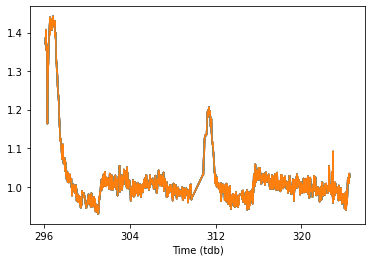

In [20]:
%matplotlib inline
plt.figure()
snPTest = [plt.plot(snTest[chunk][0],
                    snTest[chunk][1].flux/np.median(snTest[chunk][1].flux))
           for chunk in range(len(snTest))
          ];
plt.show()

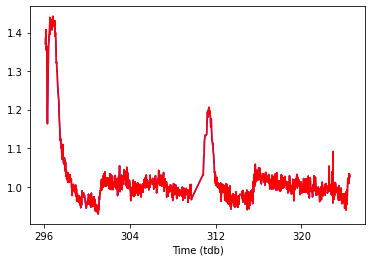

In [21]:
#snATest= np.array(snTest)
plt.plot(snTest[0][0],snTest[0][1].flux/np.median(snTest[0][1].flux),color='blue')
plt.plot(snTest[1][0],snTest[1][1].flux/np.median(snTest[1][1].flux),color='red')
plt.show()

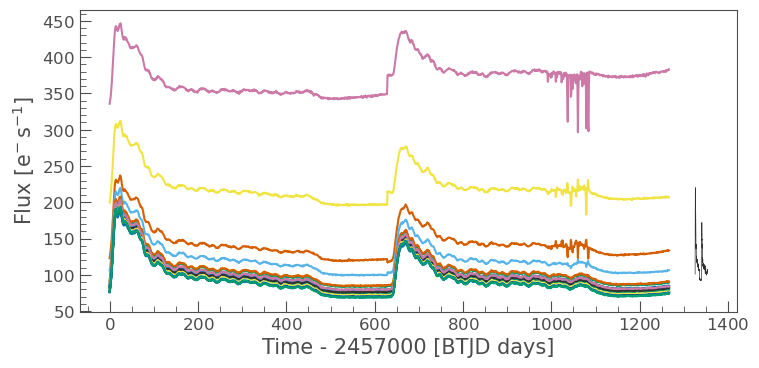

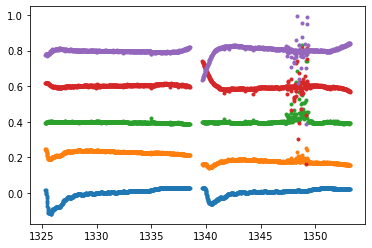

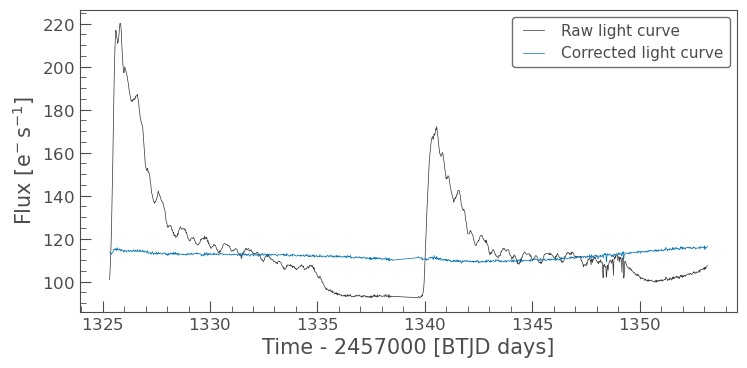

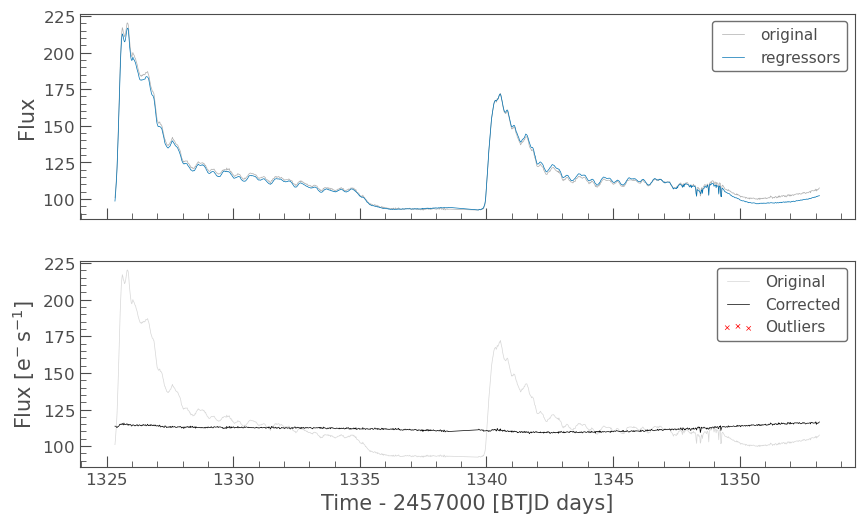

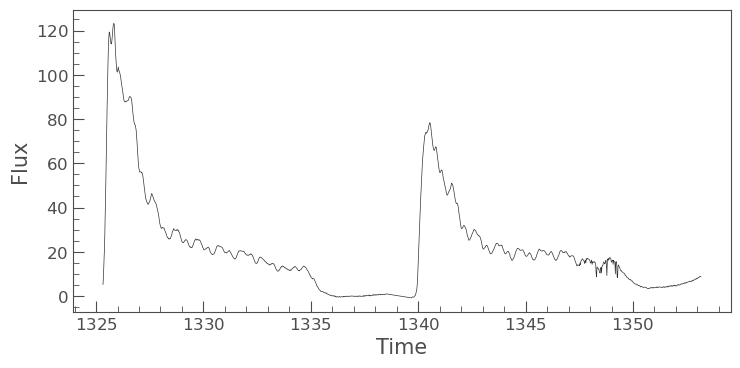

In [22]:
#snStats(radec='04 18 06.149 −63 36 56.68', sector=1, peak='2018-08-27 07:55:12.000',
#        plot=True,targetName='ASASSN-18tb',verbose=True)
targ = SkyCoord('04 18 06.149 −63 36 56.68',unit=(u.hourangle,u.deg));
tpf = lk.search_tesscut(targ,sector=1).download(cutout_size=(31,31))
aper = tpf.create_threshold_mask()
raw_lc = tpf.to_lightcurve(aperture_mask=aper)
raw_lc.plot()
regressors = tpf.flux[:, ~aper]
plt.plot(regressors[:, :30]);
plt.show()

dm = lk.DesignMatrix(regressors, name='regressors')
dm = dm.pca(5)
plt.plot(tpf.time, dm.values + np.arange(5)*0.2, '.');
plt.show()

dm = dm.append_constant()
corrector = lk.RegressionCorrector(raw_lc)
corrected_lc = corrector.correct(dm)
ax = raw_lc.plot(label='Raw light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');
plt.show()

corrector.diagnose();
model = corrector.model_lc
model -= np.percentile(model.flux, 5)
model.plot();
plt.show()

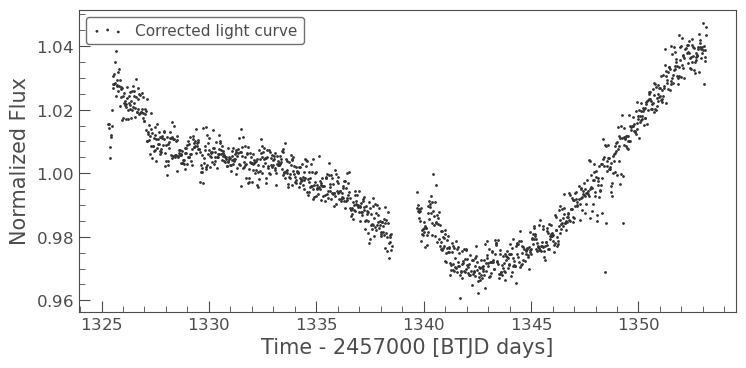

In [23]:
corrected_lc = raw_lc - model
#ax = raw_lc.plot(label='Raw light curve',normalize=True)
ax = corrected_lc.scatter( label='Corrected light curve',normalize=True);

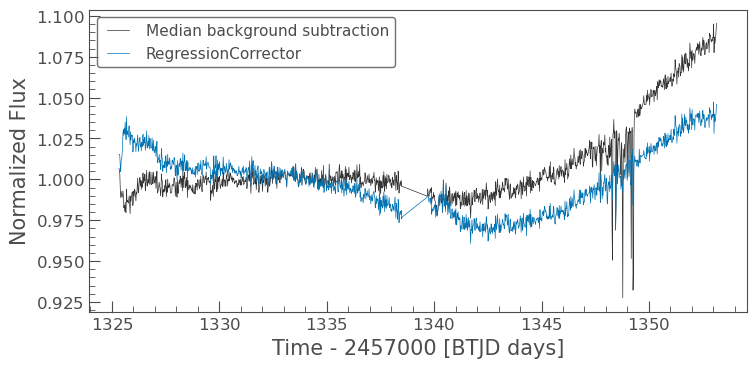

In [24]:
bkg = np.median(regressors, axis=1)
bkg -= np.percentile(bkg, 5)

npix = aper.sum()
median_subtracted_lc = raw_lc - npix * bkg

ax = median_subtracted_lc.plot(label='Median background subtraction',normalize=True)
corrected_lc.plot(ax=ax, label='RegressionCorrector',normalize=True);

In [25]:
s1 = eleanor.Source(gaia=4676041915767041280,sector=1);
s2 = eleanor.Source(gaia=4676043427595528448,sector=1);

d1 = eleanor.TargetData(s1)
d2 = eleanor.TargetData(s2)

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


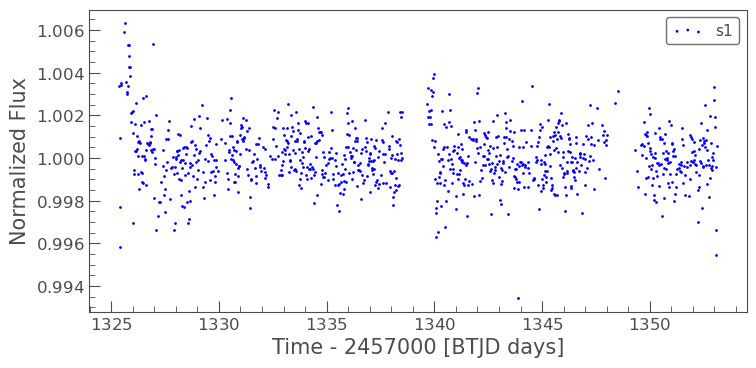

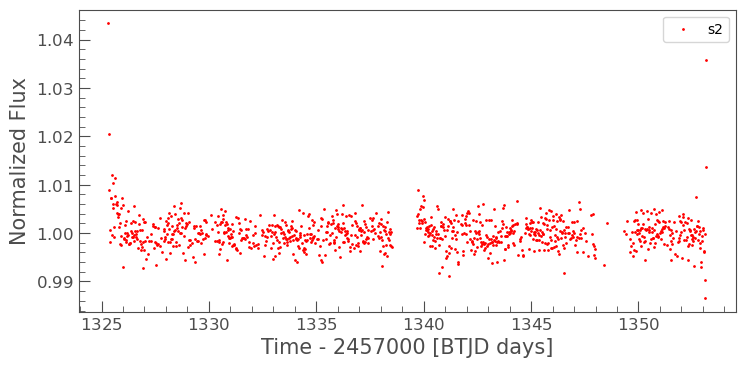

In [26]:
d1k = d1.to_lightkurve().remove_outliers()
d2k = d2.to_lightkurve()
d1k.scatter(normalize=True,color='blue',label='s1')
d2k.scatter(normalize=True,color='red',label='s2')
plt.legend()
#correction = raw_lc - 0.5*(d1k + d2k)

In [27]:
d1p=d1k.to_pandas()
d2p=d2k.to_pandas()
d2p

,time,flux,flux_err
0,1325.324066,286.242461,0.678385
1,1325.344900,279.970457,0.684127
2,1325.365733,276.797432,0.693270
3,1325.386567,273.851266,0.702737
4,1325.407401,274.507652,0.715219
...,...,...,...
989,1353.074433,270.677246,0.673753
990,1353.095266,271.691150,0.674487
991,1353.116100,274.294855,0.674504
992,1353.136933,278.094541,0.674585


In [28]:
def interpToMatch(item1,item2): 
    item1_indexed = item1.set_index('time')
    item2_indexed = item2.set_index('time')
    #display(item1_indexed)
    item1_length = len(item1_indexed.index)
    item2_length = len(item2_indexed.index)
    #display(item1_length)
    if item1_length >= item2_length:
        minun = item2_indexed.index.min()
        plusle = item2_indexed.index.max()
        numPoints = item2_length
    elif item1_length <= item2_length:
        minun = item1_indexed.index.min()
        plusle = item1_indexed.index.max()
        numPoints = item1_length
    #display(minun)
    #display(plusle)
    
    #numPoints = abs(plusle-minun)
    newIndex = np.linspace(minun,plusle-1,numPoints)
    #display(numPoints)
    #display(newIndex)
    
    item1_interp = pd.DataFrame(index=newIndex)
    item1_interp.index.name = item1_indexed.index.name
    item2_interp = pd.DataFrame(index=newIndex)
    item2_interp.index.name = item2_indexed.index.name

    for colname, col in item1_indexed.iteritems():
        item1_interp[colname] = np.interp(newIndex,item1_indexed.index,col)
    for colname, col in item2_indexed.iteritems():
        item2_interp[colname] = np.interp(newIndex,item2_indexed.index,col)
    item1_interp.reset_index(inplace=True)
    item2_interp.reset_index(inplace=True)
    
    return item1_interp, item2_interp

In [29]:
def interpToData(data, *args):
    interpArray = []
    
    data_indexed = data.set_index('time')
    data_length = len(data_indexed.index)
    minun = data_indexed.index.min()
    plusle = data_indexed.index.max()
    newIndex = np.linspace(minun,plusle-1,data_length)
    
    for arg in args:
        arg_indexed = arg.set_index('time')
        arg_interp = pd.DataFrame(index=newIndex)
        arg_interp.index.name = arg_indexed.index.name
        for colname, col in arg_indexed.iteritems():
            arg_interp[colname] = np.interp(newIndex,arg_indexed.index,col)
        arg_interp.reset_index(inplace=True)
        interpArray.append(arg_interp)
    return interpArray

In [30]:
snp = raw_lc.to_pandas()
#display_side_by_side(d1p, interpToData(d1p,d2p)[0])
d1pInterp, d2pInterp = interpToData(snp,d1p,d2p)
avgFlux = pd.DataFrame(index=snp.index)
avgFlux['time'] = 0.5 * (d1pInterp['time'] + d2pInterp['time'])
avgFlux['flux'] = 0.5 * (d1pInterp['flux'] + d2pInterp['flux']) 
avgFlux['flux_err'] = 0.5 * (d1pInterp['flux_err'] + d2pInterp['flux_err']) 
display_side_by_side(snp, avgFlux)
#interp1, interp2 = interpToData(d1p,d2p) 

,time,flux,flux_err
0,1325.323975,101.025314,0.311233
1,1325.344788,104.936996,0.315863
2,1325.365662,109.992569,0.321745
3,1325.386475,115.495407,0.328168
4,1325.407288,122.584808,0.336096
5,1325.428162,132.587128,0.347018
6,1325.448975,143.549301,0.358239
7,1325.469788,154.830078,0.369822
8,1325.490662,167.464111,0.382361
9,1325.511475,180.661057,0.394856


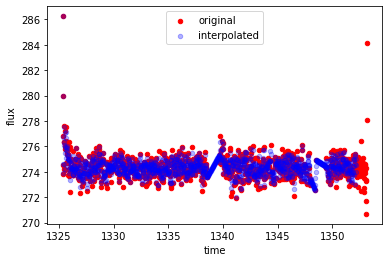

In [31]:
ax = d2p.plot(x='time',y='flux',color='red',label='original',kind='scatter')
d2pInterp.plot(x='time',y='flux',color='blue',label='interpolated',alpha=0.3,kind='scatter',ax=ax)
plt.legend()

,time,flux,flux_err,norm_flux
0,1325.323975,101.025314,0.311233,0.908528
1,1325.344788,104.936996,0.315863,0.943706
2,1325.365662,109.992569,0.321745,0.989171
3,1325.386475,115.495407,0.328168,1.038658
4,1325.407288,122.584808,0.336096,1.102414
5,1325.428162,132.587128,0.347018,1.192365
6,1325.448975,143.549301,0.358239,1.290949
7,1325.469788,154.830078,0.369822,1.392398
8,1325.490662,167.464111,0.382361,1.506017
9,1325.511475,180.661057,0.394856,1.624698


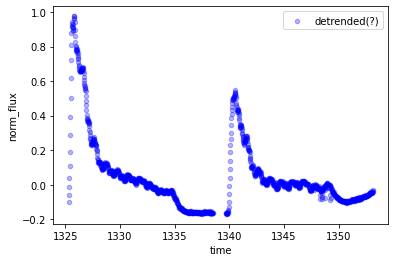

In [32]:
# targ = SkyCoord('04 18 06.149 −63 36 56.68',unit=(u.hourangle,u.deg));
# tpf = lk.search_tesscut(targ,sector=1).download(cutout_size=(31,31))
# aper = tpf.create_threshold_mask()
# raw_lc = tpf.to_lightcurve(aperture_mask=aper)

snp['norm_flux'] = snp['flux']/np.median(snp['flux'])
avgFlux['norm_flux'] = avgFlux['flux']/np.median(avgFlux['flux'])
detrend = pd.DataFrame(index=snp.index)
detrend['time'] = snp['time']
detrend['norm_flux'] = snp['norm_flux'] - avgFlux['norm_flux']
display_side_by_side(snp,detrend)
#snp.plot(x='time',y='norm_flux',kind='scatter',color='red',label='original')
detrend.plot(x='time',y='norm_flux',kind='scatter',color='blue',
             alpha=0.3,label='detrended(?)')
plt.legend()
